In [25]:
#PATH_data = f"../abyss_data/"
#Mount external drive: sudo mount -t drvfs D: /mnt/d
PATH_data = f"/mnt/d/abyss_data/"
PATH_GENO = f"{PATH_data}genotype"
PATH_SUMSTAT = f"{PATH_GENO}/sumstat/"
PATH_SUMSTAT_no_corr = f"{PATH_data}sumstat_no_corr"
PATH_GENO_segmented = f"{PATH_GENO}/segmented/"
PATH_GENO_mini_dim = f"{PATH_GENO}/mini_dim/"
PATH_GENO_maf = f"{PATH_GENO}/maf/"


PATH_PHENO = f"{PATH_data}phenotype/"
PATH_PHENO_ancestry = f"{PATH_PHENO}/ancestry/all.panel"
PATH_PLOTS = f"{PATH_data}plots/"
PATH_PARAMS = './hyper_params_to_test_AF.txt'

In [26]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import pandas as pd  # Import Pandas and Numpy to create databases
from collections import Counter
import os
from os import listdir
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'

In [27]:
effect = 1
chrom = 21
sigmap = 3

# If you happen to have labelled population data, we can create a synthetic phenotype containing population stratification

path_humans = PATH_PHENO_ancestry
humans = pd.read_csv(path_humans, sep="\t")
humans = humans.drop(columns=['Unnamed: 5', 'Unnamed: 6'])
humans = humans.rename({'sample': 'FID', 'sample.1': 'IID'}, axis=1)
humans['ancestry'] = humans['super_pop']
humans['ancestry'].mask(humans['super_pop'] == 'AFR', 0, inplace=True)
humans['ancestry'].mask(humans['super_pop'] == 'AMR', 1, inplace=True)
humans['ancestry'].mask(humans['super_pop'] == 'EAS', 2, inplace=True)
humans['ancestry'].mask(humans['super_pop'] == 'EUR', 3, inplace=True)
humans['ancestry'].mask(humans['super_pop'] == 'SAS', 4, inplace=True)

# Make synthetic phenotype with no population stratification and no causal effect

afr = humans.loc[humans['ancestry'] == 0]
amr = humans.loc[humans['ancestry'] == 1]
eas = humans.loc[humans['ancestry'] == 2]
eur = humans.loc[humans['ancestry'] == 3]
sas = humans.loc[humans['ancestry'] == 4]

mu, sigma = 150, sigmap  # mean and standard deviation for africans
afr["no_strat_no_causal"] = np.random.normal(mu, sigma, len(afr))
afr["bias_no_strat"] = 150
mu, sigma = 150, sigmap  # mean and standard deviation for americans
amr["no_strat_no_causal"] = np.random.normal(mu, sigma, len(amr))
amr["bias_no_strat"] = 150
mu, sigma = 150, sigmap  # mean and standard deviation for east asians
eas["no_strat_no_causal"] = np.random.normal(mu, sigma, len(eas))
eas["bias_no_strat"] = 150
mu, sigma = 150, sigmap  # mean and standard deviation for europeans
eur["no_strat_no_causal"] = np.random.normal(mu, sigma, len(eur))  # 4
eur["bias_no_strat"] = 150
mu, sigma = 150, sigmap  # mean and standard deviation for south east asians
sas["no_strat_no_causal"] = np.random.normal(mu, sigma, len(sas))  # 5
sas["bias_no_strat"] = 150

# Make synthetic phenotype with population stratification and no causal effect

mu, sigma = 190, sigmap  # mean and standard deviation for africans
afr["strat_no_causal"] = np.random.normal(mu, sigma, len(afr))
afr["bias_strat"] = 180
mu, sigma = 170, sigmap  # mean and standard deviation for americans
amr["strat_no_causal"] = np.random.normal(mu, sigma, len(amr))
amr["bias_strat"] = 170
mu, sigma = 150, sigmap  # mean and standard deviation for east asians
eas["strat_no_causal"] = np.random.normal(mu, sigma, len(eas))
eas["bias_strat"] = 150
mu, sigma = 180, sigmap  # mean and standard deviation for europeans
eur["strat_no_causal"] = np.random.normal(mu, sigma, len(eur))  # 4
eur["bias_strat"] = 175
mu, sigma = 160, sigmap  # mean and standard deviation for south east asians
sas["strat_no_causal"] = np.random.normal(mu, sigma, len(sas))  # 5
sas["bias_strat"] = 160
humans = pd.concat([afr, amr, eas, eur, sas]).sort_index()


/tmp/ipykernel_3672/3265141721.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  afr["no_strat_no_causal"] = np.random.normal(mu, sigma, len(afr))
/tmp/ipykernel_3672/3265141721.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  afr["bias_no_strat"] = 150
/tmp/ipykernel_3672/3265141721.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [29]:
humans['no_strat_causal'] = humans['no_strat_no_causal']
humans['strat_causal'] = humans['strat_no_causal']

path_genos = PATH_GENO_segmented + f"chrom_{chrom}/unshuffled/"


In [69]:
maf_causal_snp = 0.001

In [70]:
onlyfiles_input = [f for f in listdir(
    path_genos) if maf_causal_snp + maf_causal_snp/5 > float(f.split('_')[5]) > maf_causal_snp - maf_causal_snp/5]


In [73]:
popped = onlyfiles_input[round(len(onlyfiles_input)/2)]
snp_nr = 0

In [74]:
snps = pd.read_pickle(path_genos+popped)
snp = snps.iloc[:, snp_nr]
name = snps.columns[snp_nr]

snp_effect = snps.iloc[:, snp_nr] * effect
#snp_effect = snps.iloc[:, snp_nr] * (effect/float(maf.split('_')[0]))

humans['no_strat_causal'] = humans['no_strat_causal'] + snp_effect
humans['strat_causal'] = humans['strat_causal'] + snp_effect

In [75]:
print(Counter(snp_effect).keys())


dict_keys([1, 0])


In [15]:
path_output = PATH_GENO + "/sumstat/"

In [16]:
sit = "strat_causal"

In [17]:
bias = np.array(humans[sit])

In [18]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

In [19]:
for file in onlyfiles_input:
    path_file = path_genos + '/' + file
    genos = pd.read_pickle(path_file)
    #AF = pd.read_pickle(path_mafs + file)
    #effect_matrix = genos - AF
    effect_matrix = genos
    X = effect_matrix
    y = bias
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    sumstat = pd.DataFrame(data={
        'snp': list(est2.pvalues.index)[1:],
        'coef': list(est2.params)[1:],
        'std_err': list(est2.bse)[1:],
        't': list(est2.tvalues)[1:],
        'P': list(est2.pvalues[1:]),
        '0.025': list(est2.conf_int()[0])[1:],
        '0.975': list(est2.conf_int()[1])[1:]
    })
    sumstat['#CHROM'] = sumstat['snp'].str[:2].astype(int)
    sumstat['POS'] = [i.split(':', 1)[0]
                      for i in list(sumstat['snp'].str[3:-5])]
    sumstat['POS'] = sumstat['POS'].astype(int)
    sumstat['-logp'] = - np.log10(sumstat['P'])
    print(sumstat)
    sumstat.to_pickle(f"{path_output}chrom_{chrom}/{file}")


                    snp      coef    std_err         t         P      0.025  \
0     21:16998015:A:G_G -1.756842   4.216743 -0.416635  0.677010 -10.028741   
1     21:43201378:A:G_A  5.378804   3.654454  1.471849  0.141289  -1.790063   
2     21:39830556:C:T_C  0.958126   1.284145  0.746120  0.455722  -1.560954   
3     21:43867844:A:G_G  0.303891   0.401354  0.757165  0.449080  -0.483436   
4     21:41253722:G:T_G  6.588656   3.871154  1.701988  0.088982  -1.005308   
...                 ...       ...        ...       ...       ...        ...   
1195  21:15318511:C:G_G  1.730462   1.459690  1.185499  0.236024  -1.132983   
1196  21:43590282:A:T_A  4.414623   3.112908  1.418167  0.156367  -1.691904   
1197  21:46400789:C:T_C -4.626204  11.040896 -0.419006  0.675277 -26.284904   
1198  21:43592576:A:C_A  4.414623   3.112908  1.418167  0.156367  -1.691904   
1199  21:27581794:C:T_C  0.183790   2.236329  0.082184  0.934512  -4.203171   

          0.975  #CHROM       POS     -logp  
0    

In [20]:
path_sumstat = PATH_SUMSTAT

chrom_files = [f for f in listdir(path_sumstat) if f != 'total_sumstat.pkl']
chrom_files = [f for f in chrom_files if f == f"chrom_{chrom}"]
sumstat_array = []
for chrom_file in chrom_files:
    sumstat_files = [f for f in listdir(path_sumstat + chrom_file + '/')]
    # first do it with the first one
    path_file = path_sumstat + chrom_file + '/' + sumstat_files[0]
    sumstats = pd.read_pickle(path_file)
    for sumstat_file in sumstat_files[1:]:
        path_file = path_sumstat + chrom_file + '/' + sumstat_file
        temp = pd.read_pickle(path_file)
        sumstats = pd.concat([sumstats,temp])
    sumstat_array.append(sumstats)

sumstats = sumstat_array[0]
for sumstat in sumstat_array[1:]:
    sumstats = pd.concat([sumstats,sumstat]) 

In [21]:
sumstats = sumstats.reset_index(drop=True)


In [22]:
running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstats.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

sumstats['cumulative_pos'] = pd.concat(cumulative_pos)
sumstats['SNP number'] = sumstats.index


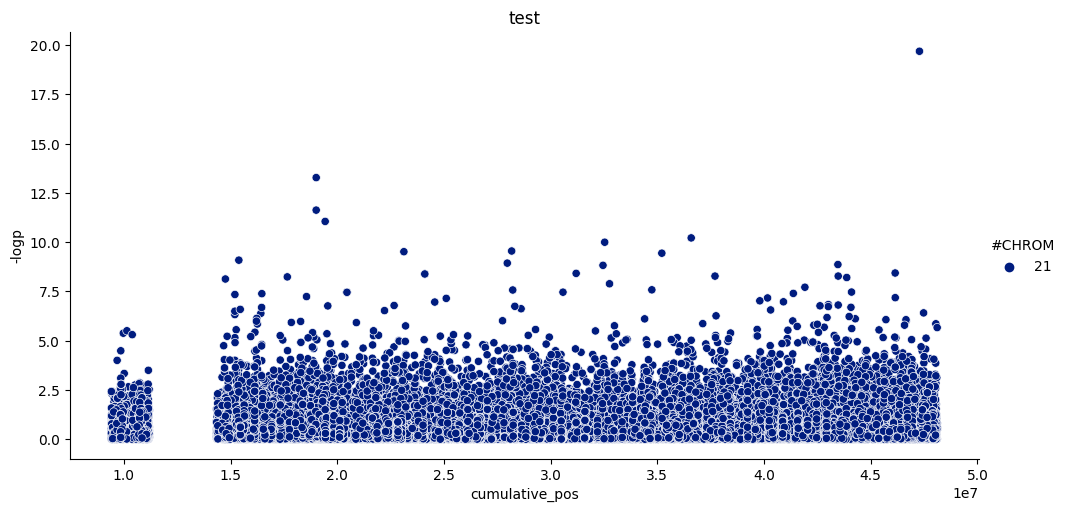

In [23]:
sns.relplot(
    data=sumstats,
    x='cumulative_pos',
    y='-logp',
    aspect=2,
    hue='#CHROM',
    palette='dark'
).set(title=f"test")
plt.savefig(f"./GWAS_Common.png")
